In [43]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#these functions are defined from CS 211 class
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def generalize(df, depths):
    return df.apply(lambda x: x.apply(lambda y: int(int(y/(10**depths[x.name]))*(10**depths[x.name]))))

# Checking for k-anonymity more efficiently
def is_k_anonymous(k, qis, df):
    """Returns true if df satisfies k-Anonymity for the quasi-identifiers 
    qis. Returns false otherwise."""
    #go through each quasi identifier
    for q in qis:
        
        #extract the column
        sub_df = df[q]
        #if the minimum of any of the columns is below k then it fails
        #the minimum value count represents the least common rows and can be identifiable 
        if (min(sub_df.value_counts()) < k):
            return False
    #if it makes it to here then the test has passed
    return True


In [44]:
#import the dataset to be used as a data frame
#encoding error if 'latin1' is not specified
census = pd.read_csv('kaggle_income.csv', encoding ='latin1')

In [45]:
#display the first 5 entries of the dataset
census.head()

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
0,1011000,1,Alabama,AL,Mobile County,Chickasaw,Chickasaw city,City,place,36611,251,10894952,909156,30.771450,-88.079697,38773,30506,33101,1638.260513
1,1011010,1,Alabama,AL,Barbour County,Louisville,Clio city,City,place,36048,334,26070325,23254,31.708516,-85.611039,37725,19528,43789,258.017685
2,1011020,1,Alabama,AL,Shelby County,Columbiana,Columbiana city,City,place,35051,205,44835274,261034,33.191452,-86.615618,54606,31930,57348,926.031000
3,1011030,1,Alabama,AL,Mobile County,Satsuma,Creola city,City,place,36572,251,36878729,2374530,30.874343,-88.009442,63919,52814,47707,378.114619
4,1011040,1,Alabama,AL,Mobile County,Dauphin Island,Dauphin Island,Town,place,36528,251,16204185,413605152,30.250913,-88.171268,77948,67225,54270,282.320328


In [46]:
#declare a master list of all the states
all_states = census['State_Name'].unique().tolist()
all_states[:5]

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California']

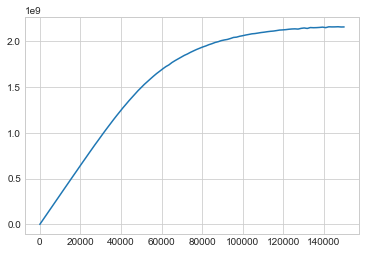

In [47]:
#to bound our data and clarify the sensitivity it's best to clip the dataset
#while this will eat up some privacy cost it can pay off

#find a clipping parameter for the mean values
def dp_income_clipping(epsilon, b):
    preprocessed_data = census['Mean'].clip(lower = 0, upper = b)
    sum_query = preprocessed_data.sum()
    return laplace_mech(sum_query, b-0, epsilon/10 )

bs = np.linspace(1, 150000, 100)
results = [dp_income_clipping(1.0, b) for b in bs]
plt.plot(bs, results);

In [48]:
#let's clip the mean information before processing to remove outliers and define the sensitivy
census['Mean'] = census['Mean'].clip(lower= 10000, upper = 140000)

In [49]:
#to find all the averages we need to define functions to compile all averages associated with each state

#this function will return the average income of any state
#using the gaussian_mech_vec we will preserve differential privacy to find the 'average of averages'
def state_avg_gaussian(state, epsilon, delta):
    #split epsilon and delta by 2 to preserve (epsilon, delta) differential privacy by sequential composition
    epsilon_i = epsilon/2
    delta_i = delta/2
    
    sensitivity = 130000 #upper - lower bounds
    
    #create array to hold all individual averages
    individual_avgs = census[(census['State_Name'] == state)]['Mean']
    #calculate the sum
    state_sum = np.sum(individual_avgs)
    #find the noisy sum using the gaussian mechanism
    noisy_sum = gaussian_mech(state_sum, sensitivity, epsilon_i, delta_i)
    
    #save the length value as k
    k = len(individual_avgs)
    noisy_count = gaussian_mech(k, 1, epsilon_i, delta_i)
    
    return noisy_sum/noisy_count

#this is the same function as above, but using laplace_mech_vec for preserving differential privacy
def state_avg_laplace(state, epsilon):
    #split epsilon and delta by 2 to preserve (epsilon, delta) differential privacy by sequential composition
    epsilon_i = epsilon/2
    
    sensitivity = 130000 #upper - lower bounds
    
    #create array to hold all individual averages
    individual_avgs = census[(census['State_Name'] == state)]['Mean']
    #calculate the sum
    state_sum = np.sum(individual_avgs)
    #find the noisy sum using the gaussian mechanism
    noisy_sum = laplace_mech(state_sum, 130000, epsilon_i)
    
    #save the length value as k
    k = len(individual_avgs)
    noisy_count = laplace_mech(k, 1, epsilon_i)
    
    return noisy_sum/noisy_count



In [50]:
#for analysis comparisons we will compare with the actual average mean in Vermont
#in the 'real world' this would be against the ethos of differential privacy
#because we are directly looking at the data
actual_vermont = census[(census['State_Name'] == 'Vermont')]['Mean'].values
actual_vermont = sum(actual_vermont)/len(actual_vermont)
print("The true mean of Vermont: ", actual_vermont)

#let's find the noisy average of income for Vermont

#first using the gaussian mechanism
result = state_avg_gaussian('Vermont', 2.0, 1e-5)
print("\nAverage using the Gaussian Mechanism: ", result)
print("Percent Error: ", pct_error(actual_vermont, result))
#next using the laplace mechanism
result = state_avg_laplace('Vermont', 2.0)
print("\nAverage using the Laplace Mechanism: ", result)
print("Percent Error: ", pct_error(actual_vermont, result))


The true mean of Vermont:  63315.97590361446

Average using the Gaussian Mechanism:  74613.46288411056
Percent Error:  17.84302748123822

Average using the Laplace Mechanism:  61942.29108506251
Percent Error:  2.169570631973044


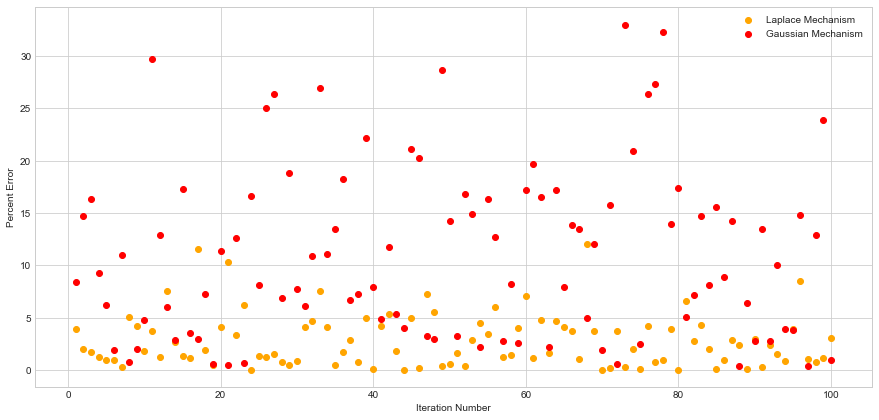

In [51]:
#lets take a closer look at the errors with each algorithm

#run the average function (with the laplace mech) 100 times and find the respective errors
laplace_runs = [state_avg_laplace('Vermont', 2.0) for _ in range (100)]
laplace_errors = [pct_error(actual_vermont, i) for i in laplace_runs]

#run the average function (with the laplace mech) 100 times and find the respective errors
gaussian_runs = [state_avg_gaussian('Vermont', 2.0, 1e-5) for _ in range (100)]
gaussian_errors = [pct_error(actual_vermont, i) for i in gaussian_runs]

x = [i for i in range(1, 101)] 
#lets display the results
plt.figure(figsize=(15,7))
lap = plt.scatter(x, laplace_errors, c = "orange")
gaus = plt.scatter(x, gaussian_errors, c = "red")
plt.xlabel("Iteration Number")
plt.ylabel("Percent Error")
plt.legend((lap, gaus), ("Laplace Mechanism", "Gaussian Mechanism"))
plt.show()

The results above show that the ranges of the two mechanisms vary with each iteration, but the Laplace Mechanism performs more accurately, more consistently.

In [52]:
#now that we can find an entire state's average we can compile a dictionary of all the states' averages
all_state_avg = {}
#loop through the states and find their respective averages
for state in all_states:
    all_state_avg[state] = state_avg_laplace(state, 2.0)
    
all_state_avg['Vermont']

62396.85941958231

In [53]:
#let's try anonymizing the data so we can perform straight computations
def generalize_census_income():
    #generalize the three least significant digits
    #this keeps the information accurate to the thousands
    depths = {
        'Mean' : 3,
        'Lat' : 4,
    }
    
    return (generalize(census[['Mean', 'Lat']], depths))

#we are now 10-k anonymous for the means
assert is_k_anonymous(10, ['Mean', 'Lat'], generalize_census_income())

In [54]:
#create an empty dictionary to hold the new averages
anon_avg = {}

def anonymized_avg(state):
    #create array to hold all individual averages
    #adult[(adult['Marital Status'] == 'Never-married')]
    individual_avgs = census[(census['State_Name'] == state)]
    noisy_sum = sum(individual_avgs['Mean'].values)
    
    #save the length value as k
    k = len(individual_avgs)
    noisy_count = laplace_mech(k, 1, 1.0)
    
    return noisy_sum/noisy_count


#loop through the states and find their respective averages
for state in all_states:
    anon_avg[state] = anonymized_avg(state)
    
result = anon_avg['Vermont']
print("Calculated Average for Vermont: ", result)
print("Percent Error: " , pct_error(actual_vermont, result))

Calculated Average for Vermont:  62907.659630037466
Percent Error:  0.6448866463000936


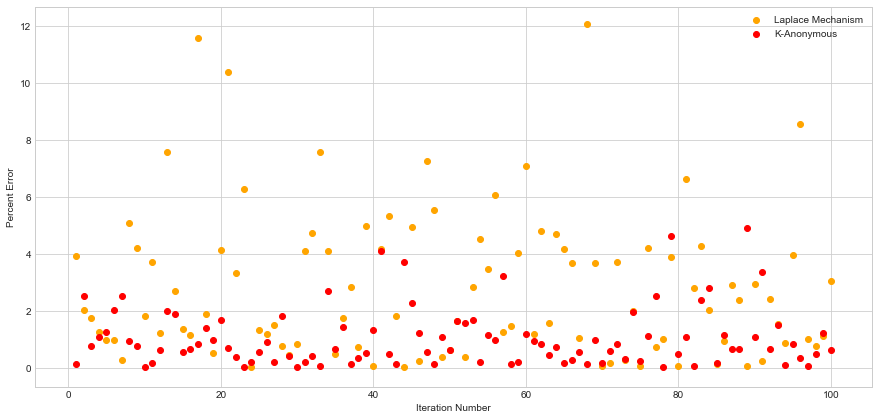

In [55]:
#now that we have two ways to calculate the averages of states lets compare 
k_anonymous_runs = [anonymized_avg('Vermont') for _ in range (100)]
k_anonymous_errors = [pct_error(actual_vermont, i) for i in k_anonymous_runs]

#lets display the results
plt.figure(figsize=(15,7))
lap = plt.scatter(x, laplace_errors, c = "orange")
k = plt.scatter(x, k_anonymous_errors, c = "red")
plt.xlabel("Iteration Number")
plt.ylabel("Percent Error")
plt.legend((lap, k), ("Laplace Mechanism", "K-Anonymous"))
plt.show()

While there is an essence of randomness when calculating the average with k-anonymity, it consistently performs more accurately than the Laplace Mechanism, which introduces much more randomness

In [56]:
#now that we have an adequate way to look into the means we can do some comparison
#this cell is using the anonymized data for finding the min and max
#find the maximum average income in the list and print
state_max = max(anon_avg, key=anon_avg.get)
print("The state with the maximum average: ", state_max)
#find the minimum average income in the list and print
state_min = min(anon_avg, key=anon_avg.get)
print("The state with the minimum average: ", state_min)

The state with the maximum average:  District of Columbia
The state with the minimum average:  Puerto Rico


In [57]:
#this cell is using the Laplace Mechanism for finding the min and max
#find the maximum average income in the list and print
state_max = max(all_state_avg, key=all_state_avg.get)
print("The state with the maximum average: ", state_max)
#find the minimum average income in the list and print
state_min = min(all_state_avg, key=all_state_avg.get)
print("The state with the minimum average: ", state_min)

The state with the maximum average:  Connecticut
The state with the minimum average:  Puerto Rico


In [58]:
#another analysis that may prove to be interesting is the correlation with mean income and the state's latitude
#i.e. how north/south the income
def avg_latitude(state):
    #create array to hold all individual averages
    individual_avgs = census[(census['State_Name'] == state)]
    noisy_sum = sum(individual_avgs['Lat'].values)
    
    #save the length value as k
    k = len(individual_avgs)
    noisy_count = laplace_mech(k, 1, 1.0)
    
    return noisy_sum/noisy_count


anon_lats = {}
#loop through the states and find their respective averages
for state in all_states:
    anon_lats[state] = avg_latitude(state)
    
result = anon_lats['Vermont']
print("Calculated Average for Vermont: ", result)

Calculated Average for Vermont:  43.53342751582774


In [59]:
avg_latitude('Vermont')

44.65192415487843

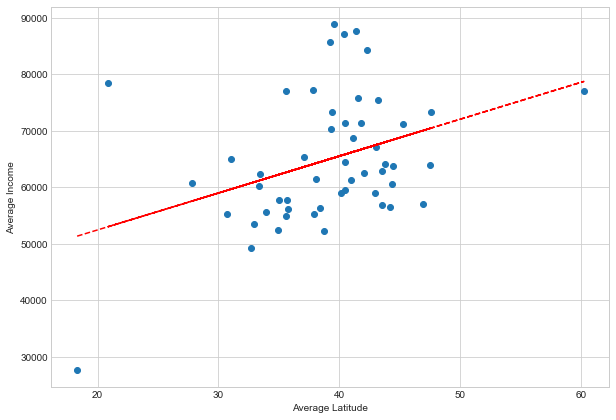

In [60]:
#create empty dictionary to match latitudes with income
combined = {}
#loop through the states to fill in the values
for state in all_states:
    combined[anon_lats[state]] = anon_avg[state]

plt.figure(figsize=(10,7))
#plot the results
plt.scatter(list(combined.keys()), list(combined.values()))
plt.xlabel("Average Latitude")
plt.ylabel("Average Income")

#create a trendline for the scatter plot
z = np.polyfit(list(combined.keys()), list(combined.values()), 1)
p = np.poly1d(z)
plt.plot(list(combined.keys()),p(list(combined.keys())),"r--")

plt.show()